# TITANIC SURVIVAL MODEL

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

### Project Objectives

The objectives of this project are
1. to assess the quality of the dataset;
2. to identify trends and patterns, hence useful insight from the dataset;
3. to build an algorithm that predict the people that are more likely to survive;

In [613]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [614]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")


### Model Evaluation

<img src="files/confusion.png" width="200" height="100">
The model is likely to make any of these errors:


1. predicting that a passenger survived when the passenger did not survive(Type 1 error(FP))
2. predicting that a passenger will not survive when the passenger survived.(Type 2 error(FN))


However, since our aim is to predict the people that are more likely to survive, the cost of predicting that a passenger will not survive when the passenger actually survived is extremely high for our aim,therefore we will try as much as possible to avoid this error.
That is the cost of missing that a passenger survived is high.Here the **Recall** is most important to us than the **accuracy** or **precision**. 

## DATA QUALITY ASSESSMENT

In [615]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [616]:
print("The Train dataset has {0} number of records, {1} features and {2} distinct passenger ID ".format(df_train.shape[0],df_train.shape[1],df_train.PassengerId.nunique()))
print("The Test dataset has {0} rows, {1} features and {2} distinct passenger ID".format(df_test.shape[0],df_test.shape[1],df_test.PassengerId.nunique()))

The Train dataset has 891 number of records, 12 features and 891 distinct passenger ID 
The Test dataset has 418 rows, 11 features and 418 distinct passenger ID


In [617]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [618]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [619]:
def find_null(df):
    """This function returns the features with missing values and the number of missing values present"""
    feature=[]
    no_null=[]
    percent=[]
    for col in df.columns:
        if df[col].isnull().sum()!=0:
            no_null.append(df[col].isnull().sum())
            feature.append(col)
            percent.append(round(((df[col].isnull().sum())/df.shape[0])*100))
        else:
            pass
    k=pd.DataFrame()
    k["Feature"]=feature
    k["No_null"]=no_null
    k["Percent%"]=percent
    return k

In [620]:
#finding the features that contains null values in train dataset
find_null(df_train)

,Feature,No_null,Percent%
0,Age,177,20
1,Cabin,687,77
2,Embarked,2,0


In [621]:
#finding the features that contains null values in test dataset
find_null(df_test)

,Feature,No_null,Percent%
0,Age,86,21
1,Fare,1,0
2,Cabin,327,78


#### Data Quality Issues, Mitigation and Recommendation.
**Incomplete Dataset**


1. The **Age** feature has 177(about 20% of the train dataset in the feature) and 86(about 21% of the test dataset in the feature) missing values and as this is likely to be a key feature the missing value will be filled based on the feature distribution.

2. The **Cabin** feature has 687(about 77% of the train data in the feature ) and 327(about 78% of the test data in the feature) missing values.

3. The **Embarked** feature has 2 missing values

4. The **Fare** feature in the test data has 1 missing value.


**Mitigation:**
    
    1. The Age feature will be filled using either the mean or the median.
    
    2. The Cabin feature will be dropped as over 70% of the feature is missing.
    
    3. The Embarked feature will be filled using the most occuring value in the feature.
    
**Recommendation:**
    
    Records should be properly checked for completeness before submission from passenger is accepted.
    
The SibSp and Parch features could have been separated as Sib,Sp and Par, Ch respectively, Also the Name column is not clearly defined. 

## What are the Features that is likely to contribute to a Passenger Survival Rate?

In [622]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Above are the 11 features that are most likely to contribute to the passenger survival rate aside the target feature

### PASSENGER SURVIVAL

<AxesSubplot:xlabel='Survived', ylabel='count'>

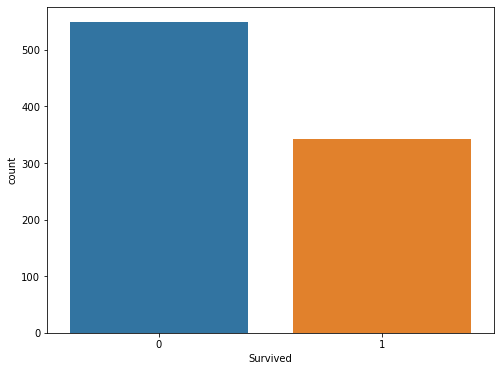

In [623]:
plt.figure(figsize=(8,6))
sns.countplot(x="Survived",data=df_train)

#### SEX

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

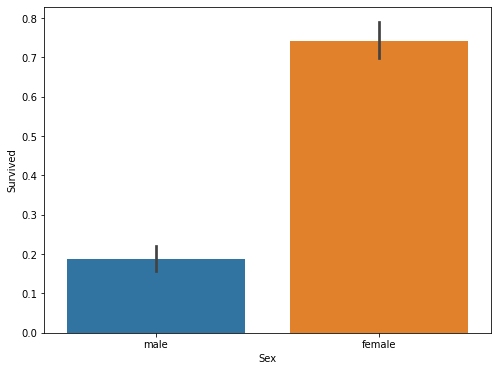

In [624]:
plt.figure(figsize=(8,6))
sns.barplot(x="Sex",y="Survived",data=df_train)

There is a higher tendency of surviving as a female

### PCLASS

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

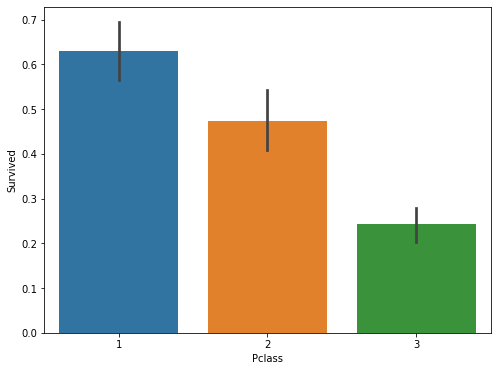

In [625]:
plt.figure(figsize=(8,6))
sns.barplot(x="Pclass",y="Survived",data=df_train)

### PORT OF EMBARKATION

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

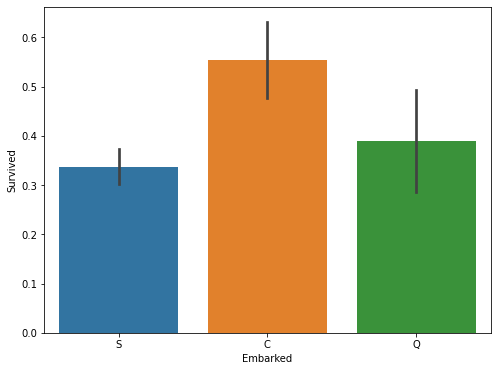

In [626]:
plt.figure(figsize=(8,6))
sns.barplot(x="Embarked",y="Survived",data=df_train)

### AGE

<AxesSubplot:xlabel='Age', ylabel='Count'>

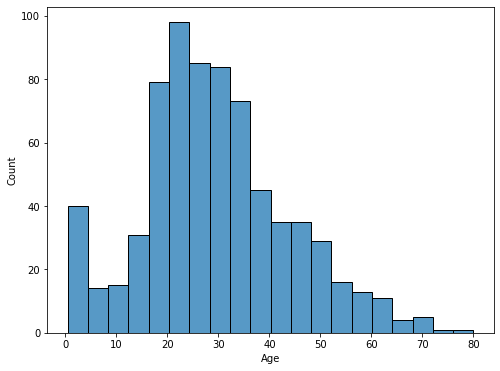

In [627]:
plt.figure(figsize=(8,6))
sns.histplot(df_train["Age"].dropna(),kde=False)

### AGE and SEX

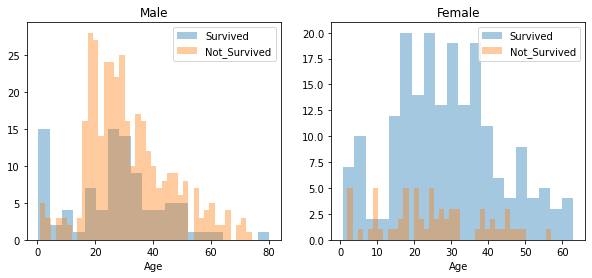

In [628]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
male=df_train[df_train["Sex"]=="male"]
female=df_train[df_train["Sex"]=="female"]
ax=sns.distplot(male[male["Survived"]==1].Age.dropna(),bins=20,label="Survived",ax=axes[0],kde=False)
ax=sns.distplot(male[male["Survived"]==0].Age.dropna(),label="Not_Survived",kde=False,ax=axes[0],bins=40)
ax.legend()
ax.set_title('Male')
ax=sns.distplot(female[female["Survived"]==1].Age.dropna(),bins=20,label="Survived",ax=axes[1],kde=False)
ax=sns.distplot(female[female["Survived"]==0].Age.dropna(),label="Not_Survived",kde=False,ax=axes[1],bins=40)
ax.legend()
_=ax.set_title('Female')


### EMBARKED, SEX AND PCLASS

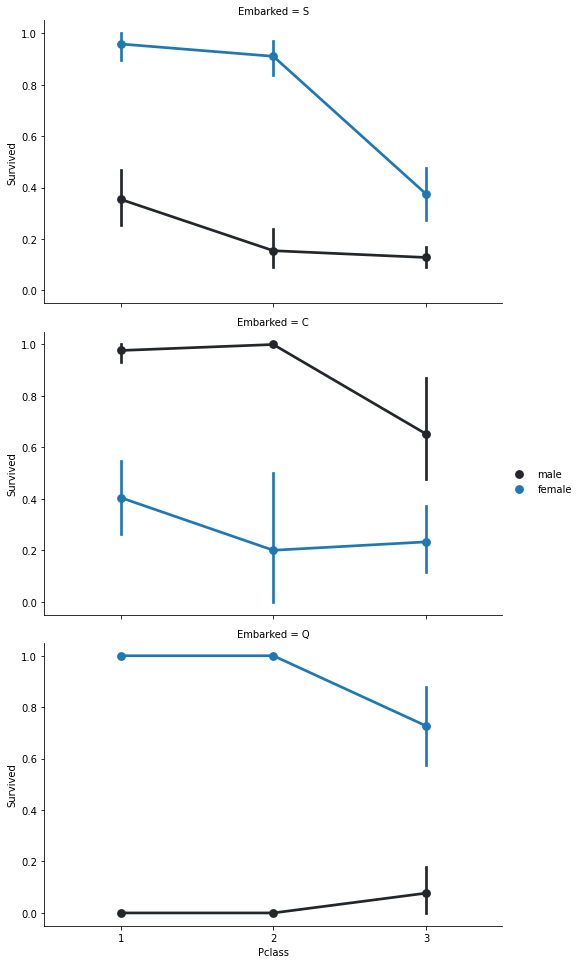

In [629]:
FacetGrid = sns.FacetGrid(df_train, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

### PCLASS AND AGE

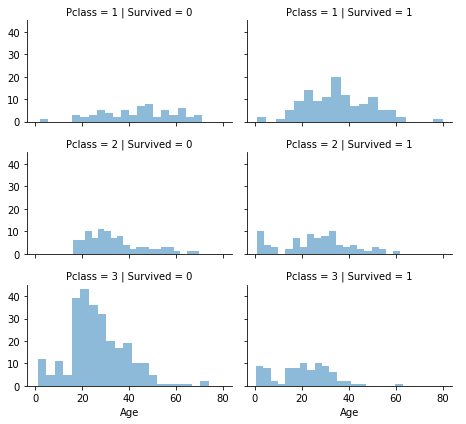

In [630]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### SibSP and ParCh

In [631]:
#Let us create 2 features from this two features called relatives and not_alone
#For the training dataset
df_train["Relatives"]=df_train["SibSp"]+df_train["Parch"]
df_train.loc[df_train["Relatives"]>0,"Not_alone"]=1
df_train.loc[df_train["Relatives"]==0,"Not_alone"]=0
df_train["Not_alone"]=df_train["Not_alone"].astype(int)
#For the test dataset
df_test["Relatives"]=df_test["SibSp"]+df_train["Parch"]
df_test.loc[df_test["Relatives"]>0,"Not_alone"]=1
df_test.loc[df_test["Relatives"]==0,"Not_alone"]=0
df_test["Not_alone"]=df_test["Not_alone"].astype(int)

#Let check how the Relatives are distributed
df_train["Not_alone"].value_counts()

0    537
1    354
Name: Not_alone, dtype: int64

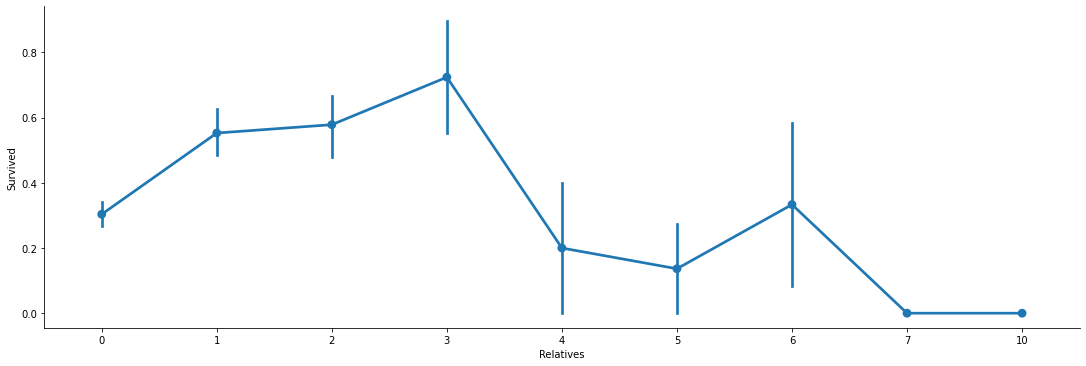

In [632]:
sns.factorplot('Relatives','Survived',data=df_train, aspect = 3)

In [633]:
import re

#Let fill the missing values in the Cabin column with U0
df_train.Cabin.fillna("U0",axis=0,inplace=True)
df_train["Cabin_letter"]=df_train["Cabin"].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())


#Let fill the missing values in the Cabin column with U0
df_test.Cabin.fillna("U0",axis=0,inplace=True)
df_test["Cabin_letter"]=df_test["Cabin"].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())

#Encoding the variable
cab={"A":0,"B":1,"C":2,"D":3,"E":4,"F":5,"G":6,"T":7,"U":7}
df_train["Cabin_letter"]=df_train["Cabin_letter"].map(cab)
df_test["Cabin_letter"]=df_test["Cabin_letter"].map(cab)
df_train["Cabin_letter"].value_counts()

7    688
2     59
1     47
3     33
4     32
0     15
5     13
6      4
Name: Cabin_letter, dtype: int64

In [634]:
#Filling the Missing Value in Age
df_train["Age"].fillna(round(df_train.Age.mean(),2),axis=0,inplace=True)  #filling the missing value with the mean value
df_test["Age"].fillna(round(df_test.Age.mean(),2),axis=0,inplace=True)

#Converting the age into age groups
bins=[0,20,30,40,50,60,90]
labels=["0-19","20-29","30-39","40-49","50-59","60+"]
clip={"0-19":0,"20-29":1,"30-39":2,"40-49":3,"50-59":4,"60+":5}
#Training Dataset
df_train["Age_group"]=pd.cut(df_train["Age"],bins,labels=labels)
df_train["Age_group"]=df_train["Age_group"].map(clip)

#Testing Dataset
df_test["Age_group"]=pd.cut(df_test["Age"],bins,labels=labels)
df_test["Age_group"]=df_test["Age_group"].map(clip)


df_train["Age_group"].value_counts()

1    407
0    179
2    155
3     86
4     42
5     22
Name: Age_group, dtype: int64

In [635]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Not_alone,Cabin_letter,Age_group
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,U0,Q,0.0,0,7,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,U0,S,1.0,1,7,3
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,U0,Q,0.0,0,7,5
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,U0,S,0.0,0,7,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,U0,S,1.0,1,7,1


In [636]:
#Let us fill the missing value in the Fare with the mean
df_train["Fare"].fillna(df_train.Fare.mean(),axis=0,inplace=True)
df_test["Fare"].fillna(df_test.Fare.mean(),axis=0,inplace=True)

#Let us also group the Fare
#Train Data
df_train.loc[ df_train['Fare'] <= np.percentile(df_train["Fare"],25), 'Fare'] = 0
df_train.loc[(df_train['Fare'] > np.percentile(df_train["Fare"],25)) & (df_train['Fare'] <= np.percentile(df_train["Fare"],50)), 'Fare'] = 1
df_train.loc[(df_train['Fare'] > np.percentile(df_train["Fare"],50)) & (df_train['Fare'] <= np.percentile(df_train["Fare"],75)), 'Fare']   = 2
df_train.loc[(df_train['Fare'] >= np.percentile(df_train["Fare"],75)), 'Fare']   = 3
df_train['Fare'] = df_train['Fare'].astype(int)

#Test Data
df_test.loc[ df_test['Fare'] <= np.percentile(df_test["Fare"],25), 'Fare'] = 0
df_test.loc[(df_test['Fare'] > np.percentile(df_test["Fare"],25)) & (df_test['Fare'] <= np.percentile(df_test["Fare"],50)), 'Fare'] = 1
df_test.loc[(df_test['Fare'] > np.percentile(df_test["Fare"],50)) & (df_test['Fare'] <= np.percentile(df_test["Fare"],75)), 'Fare']   = 2
df_test.loc[(df_test['Fare'] >= np.percentile(df_test["Fare"],75)), 'Fare']   = 3
df_test['Fare'] = df_test['Fare'].astype(int)

In [637]:
#Fill the Embarked feature with the most occuring value
df_train["Embarked"].fillna(df_train["Embarked"].mode()[0],axis=0,inplace=True)
ports={"S":0,"C":1,"Q":2}

#Encoding Embarked Feature
df_train["Embarked"]=df_train["Embarked"].map(ports)
df_test["Embarked"]=df_test["Embarked"].map(ports)

In [638]:
#We can Extract the title of each passenger
df_train["Title"]=df_train["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())
df_test["Title"]=df_test["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())

df_train["Title"]=df_train["Title"].replace(["Dr","Rev","Col","Major","Jonkheer","Capt","Lady","Don","Sir","the Countess","Master","Mlle","Ms","Mme"],"Others")
df_test["Title"]=df_test["Title"].replace(["Dr","Rev","Col","Major","Jonkheer","Capt","Lady","Don","Sir","the Countess","Master","Mlle","Ms","Mme","Dona"],"Others")

#Encoding The Title
tit={"Mr":1,"Miss":2,"Mrs":3,"Others":4}
df_train["Title"]=df_train["Title"].map(tit)
df_test["Title"]=df_test["Title"].map(tit)

df_train["Title"].value_counts()

1    517
2    182
3    125
4     67
Name: Title, dtype: int64

In [639]:
#Encoding the Sex
sex={"male":0,"female":1}
df_train["Sex"]=df_train["Sex"].map(sex)
df_test["Sex"]=df_test["Sex"].map(sex)


In [640]:
#Creating new features
df_train["Age_group"]=df_train["Age_group"].astype(int)
df_test["Age_group"]=df_test["Age_group"].astype(int)

df_train["Age_class"]=df_train["Age_group"]*df_train["Pclass"]
df_test["Age_class"]=df_test["Age_group"]*df_test["Pclass"]


df_train["Fare_per_person"]=df_train["Fare"]/(df_train["Relatives"]+1)
df_test["Fare_per_person"]=df_test["Fare"]/(df_test["Relatives"]+1)

In [641]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      891 non-null    int64  
 1   Survived         891 non-null    int64  
 2   Pclass           891 non-null    int64  
 3   Name             891 non-null    object 
 4   Sex              891 non-null    int64  
 5   Age              891 non-null    float64
 6   SibSp            891 non-null    int64  
 7   Parch            891 non-null    int64  
 8   Ticket           891 non-null    object 
 9   Fare             891 non-null    int32  
 10  Cabin            891 non-null    object 
 11  Embarked         891 non-null    int64  
 12  Relatives        891 non-null    int64  
 13  Not_alone        891 non-null    int32  
 14  Cabin_letter     891 non-null    int64  
 15  Age_group        891 non-null    int32  
 16  Title            891 non-null    int64  
 17  Age_class       

In [642]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      418 non-null    int64  
 1   Pclass           418 non-null    int64  
 2   Name             418 non-null    object 
 3   Sex              418 non-null    int64  
 4   Age              418 non-null    float64
 5   SibSp            418 non-null    int64  
 6   Parch            418 non-null    int64  
 7   Ticket           418 non-null    object 
 8   Fare             418 non-null    int32  
 9   Cabin            418 non-null    object 
 10  Embarked         418 non-null    int64  
 11  Relatives        418 non-null    float64
 12  Not_alone        418 non-null    int32  
 13  Cabin_letter     418 non-null    int64  
 14  Age_group        418 non-null    int32  
 15  Title            418 non-null    int64  
 16  Age_class        418 non-null    int64  
 17  Fare_per_person 

In [643]:
df_train.drop(["PassengerId","Name","Age","Ticket","Cabin"],axis=1,inplace=True)
df_test.drop(["Name","Age","Ticket","Cabin"],axis=1,inplace=True)

In [644]:
df_test.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,Relatives,Not_alone,Cabin_letter,Age_group,Title,Age_class,Fare_per_person
0,892,3,0,0,0,0,2,0.0,0,7,2,1,6,0.0
1,893,3,1,1,0,0,0,1.0,1,7,3,3,9,0.0
2,894,2,0,0,0,1,2,0.0,0,7,5,1,10,1.0
3,895,3,0,0,0,1,0,0.0,0,7,1,1,3,1.0
4,896,3,1,1,1,1,0,1.0,1,7,1,3,3,0.5


## Building Machine Learning Models

In [645]:
#Lets split the data 
X_train = df_train.drop("Survived", axis=1)
y_train = df_train["Survived"]
X_test  = df_test.drop("PassengerId", axis=1).copy()

## Stochastic Gradient Descent

In [647]:
from sklearn.linear_model import SGDClassifier
sgd_model=SGDClassifier(max_iter=5, tol=None)
sgd_model.fit(X_train,y_train)
y_pred=sgd_model.predict(X_test)
acc_sgd = round(sgd_model.score(X_train, y_train) * 100, 2)

### Logistic Regression

In [648]:
from sklearn.linear_model import LogisticRegression
log_model=LogisticRegression()
log_model.fit(X_train,y_train)
y_pred=log_model.predict(X_test)
acc_log=round(log_model.score(X_train,y_train)*100,2)

### Perceptron

In [651]:
from sklearn.linear_model import Perceptron
percept= Perceptron(max_iter=5)
percept.fit(X_train, y_train)

y_pred = percept.predict(X_test)

acc_percept = round(percept.score(X_train, y_train) * 100, 2)

### Random Forest

In [653]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred= rf_model.predict(X_test)
acc_rf = round(rf_model.score(X_train, y_train) * 100, 2)

### KNN

In [655]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, y_train)
y_pred =knn_model.predict(X_test)
acc_knn = round(knn_model.score(X_train, y_train) * 100, 2)

### Gaussian Naive Bayes

In [656]:
from sklearn.naive_bayes import GaussianNB
gaussian_model = GaussianNB()
gaussian_model.fit(X_train, y_train)
y_pred = gaussian_model.predict(X_test)
acc_gaussian = round(gaussian_model.score(X_train, y_train) * 100, 2)

### Linear Support Vector Machine

In [657]:
from sklearn.svm import LinearSVC
svc_model = LinearSVC()
svc_model.fit(X_train, y_train)
y_pred =svc_model.predict(X_test)
acc_linear_svc = round(svc_model.score(X_train, y_train) * 100, 2)

In [658]:
from sklearn.tree import DecisionTreeClassifier
dt_model= DecisionTreeClassifier() 
dt_model.fit(X_train, y_train)  
y_pred = dt_model.predict(X_test)  
acc_dt = round(dt_model.score(X_train, y_train) * 100, 2)

### Which of the Models Performed Well?

In [661]:
models=["SGD","Logistic Regression","Perceptron","Random Forest","KNN","Gaussian NB","Linear SVC","Decision Tree"]
score=[acc_sgd,acc_log,acc_percept,acc_rf,acc_knn,acc_gaussian,acc_linear_svc,acc_dt]
model_df=pd.DataFrame()
model_df["Models"]=models
model_df["Accuracy_Score"]=score
model_df=model_df.sort_values(by="Accuracy_Score",ascending=False)
model_df=model_df.set_index("Models")

In [662]:
model_df

,Accuracy_Score
Models,
Random Forest,91.02
Decision Tree,91.02
KNN,84.29
Perceptron,82.27
Logistic Regression,81.82
Linear SVC,81.82
SGD,80.47
Gaussian NB,79.57


### K-FOLD CROSS VALIDATION

In [663]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.76666667 0.84269663 0.76404494 0.87640449 0.85393258 0.80898876
 0.80898876 0.79775281 0.86516854 0.82022472]
Mean: 0.8204868913857677
Standard Deviation: 0.03687647752915873


### Feature Importance

In [664]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf_model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.208
Sex,0.195
Cabin_letter,0.101
Pclass,0.081
Age_class,0.080
Fare_per_person,0.064
Age_group,0.059
Embarked,0.055
Relatives,0.050


<AxesSubplot:xlabel='feature'>

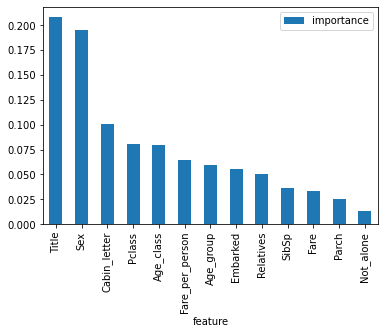

In [665]:
importances.plot.bar()

In [666]:
#Let us drop Parch and Not_alone
df_train  = df_train.drop("Not_alone", axis=1)
df_test  = df_test.drop("Not_alone", axis=1)

df_train  = df_train.drop("Parch", axis=1)
df_test  = df_test.drop("Parch", axis=1)

In [667]:
#Let train the model again
rf_model = RandomForestClassifier(n_estimators=100, oob_score = True)
rf_model.fit(X_train, y_train)
Y_prediction = rf_model.predict(X_test)

acc_random_forest = round(rf_model.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest,2), "%")

91.02 %


### Hyperparameter Tuning

In [670]:
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}


from sklearn.model_selection import GridSearchCV, cross_val_score

rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 700}

In [678]:
# Random Forest
rf_model = RandomForestClassifier(criterion = "entropy", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=700, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

rf_model.fit(X_train, y_train)
y_prediction = rf_model.predict(X_test)

acc_random_forest = round(rf_model.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest,2), "%")

88.44 %


In [680]:
sub=pd.read_csv("gender_submission.csv")
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [681]:
sub["Survived"]=y_prediction
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [684]:
sub.to_csv("my_1submission.csv",index=False)